#Import all the required libraries

In [6]:
# Import all the required libraries
import pandas as pd
import datetime as dt
from datetime import date
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np
import tensorflow as tf

In [7]:
# Define start day to fetch the dataset from Yahoo Finance
START = "2010-01-01"
TODAY = "2025-07-02"  # Till 2nd July, 2025

In [9]:
# Define a function to load the dataset
def load_data(ticker):
    data = yf.download(ticker, START, TODAY)
    data.reset_index(inplace=True)
    return data

# Load BTC-USD Data and Drop Columns

2014-09-17 — that’s the first day of available OHLCV (Open, High, Low, Close, Volume) data.

In [10]:
# Load the data for Bitcoin
data = load_data('BTC-USD')
df = data.copy()  # Keep full data with 'Date'

# Drop only 'Adj Close' if it exists
if 'Adj Close' in df.columns:
    df = df.drop(['Adj Close'], axis=1)

df.head()

/tmp/ipython-input-9-2981024786.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, START, TODAY)
[*********************100%***********************]  1 of 1 completed


Price,Date,Close,High,Low,Open,Volume
Ticker,,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
0,2014-09-17,457.334015,468.174011,452.421997,465.864014,21056800
1,2014-09-18,424.440002,456.859985,413.104004,456.859985,34483200
2,2014-09-19,394.795990,427.834991,384.532013,424.102997,37919700
3,2014-09-20,408.903992,423.295990,389.882996,394.673004,36863600
4,2014-09-21,398.821014,412.425995,393.181000,408.084991,26580100


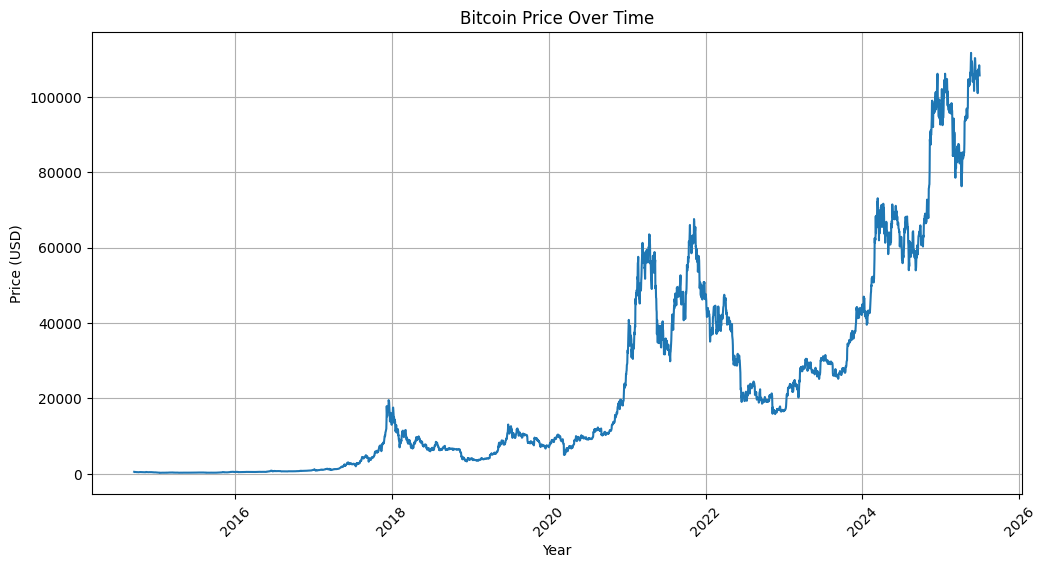

In [11]:
# Visualizing Closing Price over time (with years)
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Close'])
plt.title("Bitcoin Price Over Time")
plt.xlabel("Year")
plt.ylabel("Price (USD)")
plt.grid(True)
plt.xticks(rotation=45)  # Rotate for readability
plt.show()

# Plotting moving averages of 100 days

In [12]:
ma100 = df.Close.rolling(100).mean()

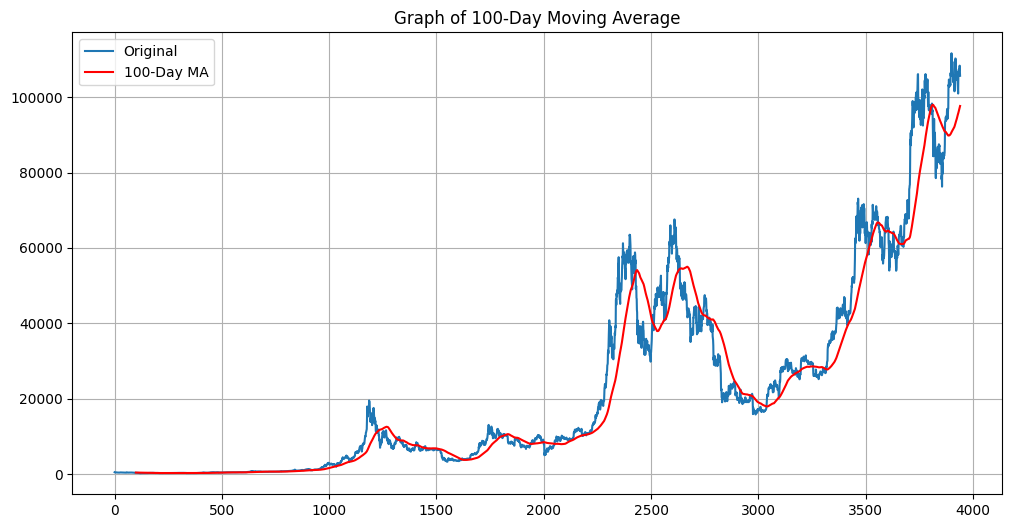

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(df.Close, label="Original")
plt.plot(ma100, 'r', label="100-Day MA")
plt.grid(True)
plt.title('Graph of 100-Day Moving Average')
plt.legend()
plt.show()

# Defining 200-day moving averages and plotting comparison graph

In [14]:
ma200 = df.Close.rolling(200).mean()

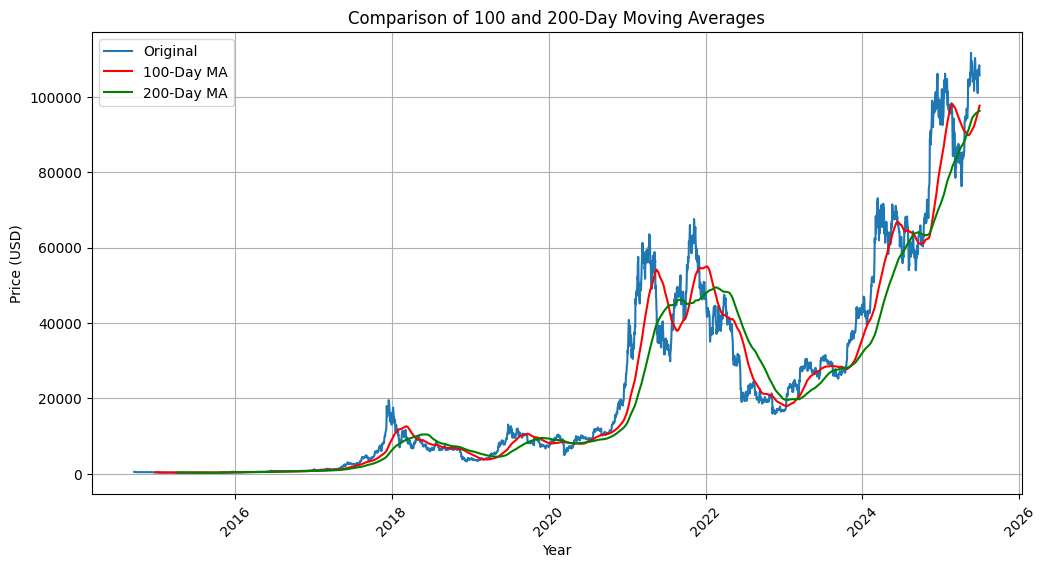

In [15]:
# Compute moving averages
ma100 = df['Close'].rolling(100).mean()
ma200 = df['Close'].rolling(200).mean()

# Plot comparison of moving averages
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Close'], label='Original')
plt.plot(df['Date'], ma100, 'r', label='100-Day MA')
plt.plot(df['Date'], ma200, 'g', label='200-Day MA')
plt.title("Comparison of 100 and 200-Day Moving Averages")
plt.xlabel("Year")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

In [16]:
# Display shape of the final dataset
df.shape

(3941, 6)

# Splitting the dataset into training (70%) and testing (30%) set


In [17]:
train = pd.DataFrame(data[0:int(len(data) * 0.70)])
test = pd.DataFrame(data[int(len(data) * 0.70): int(len(data))])

print("Training Set Shape:", train.shape)
print("Testing Set Shape:", test.shape)

train.head()

Training Set Shape: (2758, 6)
Testing Set Shape: (1183, 6)


Price,Date,Close,High,Low,Open,Volume
Ticker,,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
0,2014-09-17,457.334015,468.174011,452.421997,465.864014,21056800
1,2014-09-18,424.440002,456.859985,413.104004,456.859985,34483200
2,2014-09-19,394.795990,427.834991,384.532013,424.102997,37919700
3,2014-09-20,408.903992,423.295990,389.882996,394.673004,36863600
4,2014-09-21,398.821014,412.425995,393.181000,408.084991,26580100


In [18]:
# Using MinMax scaler for normalization of the dataset
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))

train_close = train.iloc[:, 4:5].values  # 'Close' column
test_close = test.iloc[:, 4:5].values

data_training_array = scaler.fit_transform(train_close)
data_training_array[:5]  # View first few scaled values

array([[0.00428907],
       [0.00415543],
       [0.00366922],
       [0.0032324 ],
       [0.00343147]])

In [19]:
# Preparing the training data
x_train = []
y_train = []

for i in range(100, data_training_array.shape[0]):
    x_train.append(data_training_array[i-100: i])
    y_train.append(data_training_array[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)

x_train shape: (2658, 100, 1)
y_train shape: (2658,)


# LSTM-based deep learning model


In [20]:
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential

model = Sequential()

model.add(LSTM(units=50, activation='relu', return_sequences=True,
               input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=60, activation='relu', return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(units=80, activation='relu', return_sequences=True))
model.add(Dropout(0.4))

model.add(LSTM(units=120, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=1))  # Final output layer

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100, 60)        │        26,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100, 60)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 100, 80)        │        45,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100, 80)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 120)            │        96,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           121 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,761 (698.29 KB)

 Trainable params: 178,761 (698.29 KB)

 Non-trainable params: 0 (0.00 B)

# Training the model


In [21]:
import tensorflow as tf

model.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.MeanAbsoluteError()])
model.fit(x_train, y_train, epochs=100)

Epoch 1/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 34s 304ms/step - loss: 0.0266 - mean_absolute_error: 0.0984
Epoch 2/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 39s 277ms/step - loss: 0.0048 - mean_absolute_error: 0.0386
Epoch 3/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 41s 278ms/step - loss: 0.0045 - mean_absolute_error: 0.0377
Epoch 4/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 23s 277ms/step - loss: 0.0039 - mean_absolute_error: 0.0345
Epoch 5/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 40s 263ms/step - loss: 0.0036 - mean_absolute_error: 0.0325
Epoch 6/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 24s 283ms/step - loss: 0.0048 - mean_absolute_error: 0.0404
Epoch 7/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 23s 280ms/step - loss: 0.0046 - mean_absolute_error: 0.0382
Epoch 8/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 40s 273ms/step - loss: 0.0037 - mean_absolute_error: 0.0344
Epoch 9/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 40s 263ms/step - loss: 0.0029 - mean_absolute_error: 0.0316
Epoch 10/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 42s 274ms/step - loss: 0.0033 - mean_absolute_error: 0.0320
Epoch 11/

In [22]:
# Save the trained model
model.save('btc_model.h5')

# Prepare Test Data

In [23]:
# Shape check for test set
print("Test close shape:", test_close.shape)

# Fetch last 100 days of training set
past_100_days = pd.DataFrame(train_close[-100:])

# Convert test close into DataFrame
test_df = pd.DataFrame(test_close)

Test close shape: (1183, 1)


In [24]:
# Final dataset for testing
# Append last 100 days of training data with test data to create input for testing
final_df = pd.concat([past_100_days, test_df], ignore_index=True)
final_df.head()

,0
0,50802.609375
1,50679.859375
2,47623.871094
3,46490.605469
4,47169.371094


In [25]:
# Normalize final input data
input_data = scaler.fit_transform(final_df)
print("Input data shape for testing:", input_data.shape)
input_data[:5]  # Optional: Preview

Input data shape for testing: (1283, 1)


array([[0.36518647],
       [0.36390645],
       [0.33203907],
       [0.32022155],
       [0.32729961]])

# Prepare Test Sequences for Prediction

In [26]:
# Preparing test sequences for prediction
x_test = []
y_test = []

for i in range(100, input_data.shape[0]):
    x_test.append(input_data[i-100:i])
    y_test.append(input_data[i, 0])

x_test, y_test = np.array(x_test), np.array(y_test)

print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_test shape: (1183, 100, 1)
y_test shape: (1183,)


In [27]:
# Making predictions using the trained model
y_pred = model.predict(x_test)

print("y_pred shape:", y_pred.shape)

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step
y_pred shape: (1183, 1)


In [28]:
# Inverse scaling of predictions and actual values

# Note: scaler.scale_ contains scaling factor for each feature; 'Close' is the first feature

scale_factor = 1 / scaler.scale_[0]

y_pred = y_pred * scale_factor
y_test = y_test * scale_factor

# Plot Predicted vs Actual Prices

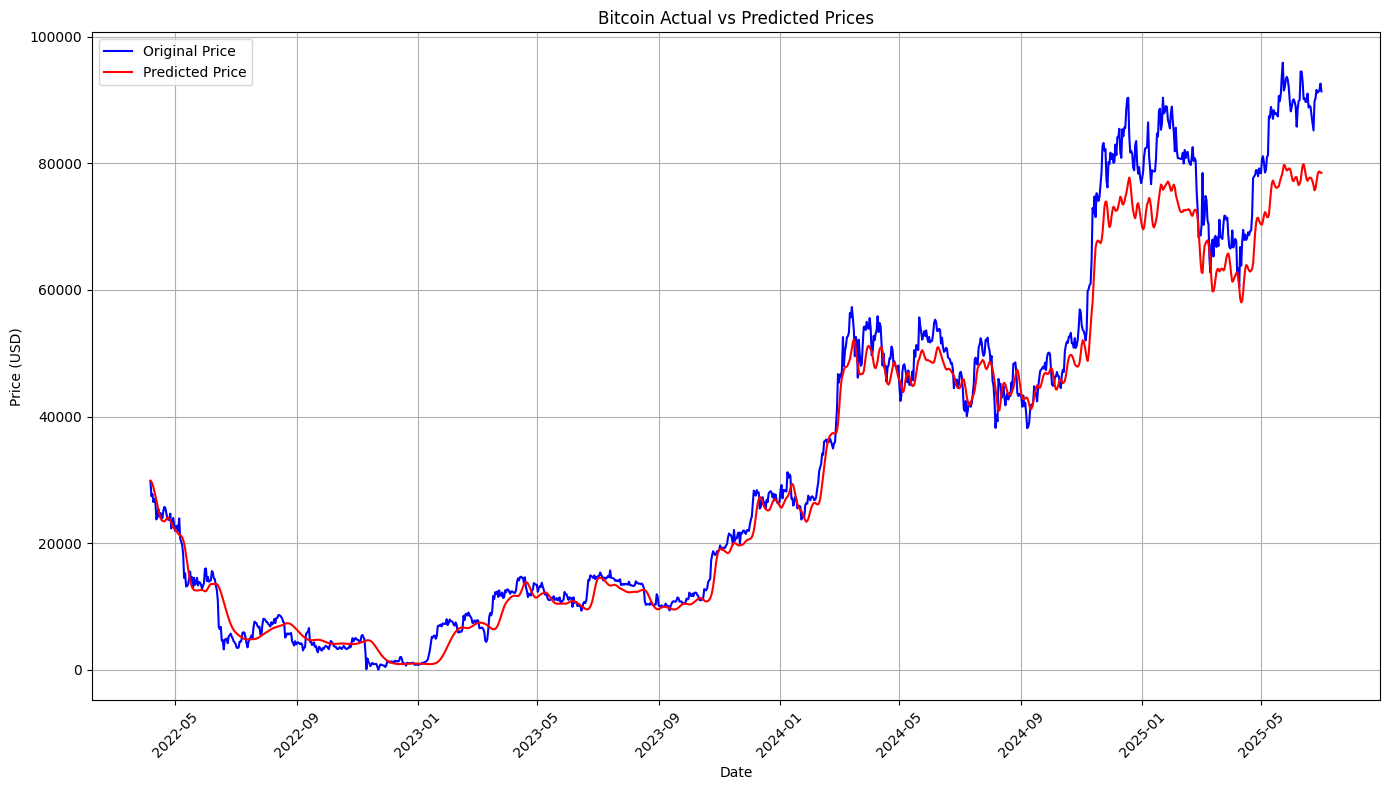

In [29]:
# Get the corresponding dates for test data
test_dates = data['Date'].iloc[int(len(data)*0.70):].reset_index(drop=True)

plt.figure(figsize=(14, 8))
plt.plot(test_dates, y_test, 'b', label="Original Price")
plt.plot(test_dates, y_pred, 'r', label="Predicted Price")
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.title('Bitcoin Actual vs Predicted Prices')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Calculate Mean Absolute Error (MAE)

In [30]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test, y_pred)
mae_percentage = (mae / np.mean(y_test)) * 100

print(f"Mean absolute error on test set: {mae_percentage:.2f}%")

Mean absolute error on test set: 9.59%


# Calculate and Plot R2 Score

R2 score: 0.9713732981445515


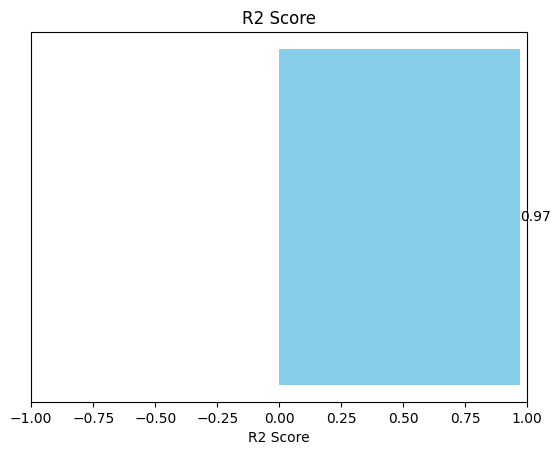

In [34]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test, y_pred)
print("R2 score:", r2)

# Plotting R2 score
fig, ax = plt.subplots()
ax.barh(0, r2, color='skyblue')
ax.set_xlim([-1, 1])
ax.set_yticks([])
ax.set_xlabel('R2 Score')
ax.set_title('R2 Score')
ax.text(r2, 0, f'{r2:.2f}', va='center', color='black')
plt.show()

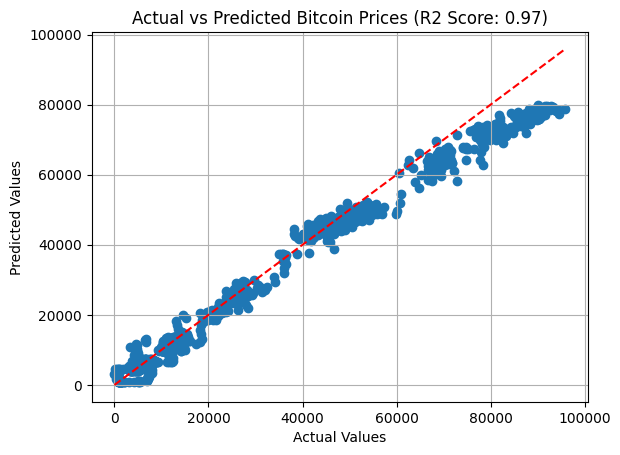

In [35]:
# Scatter Plot of Actual vs Predicted Values
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'Actual vs Predicted Bitcoin Prices (R2 Score: {r2:.2f})')
plt.grid(True)
plt.show()

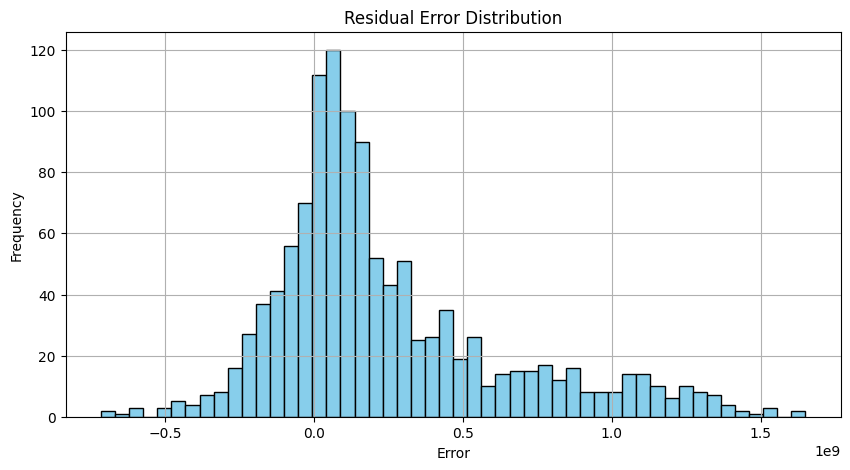

In [59]:
residuals = y_test - y_pred.flatten()

plt.figure(figsize=(10, 5))
plt.hist(residuals, bins=50, color='skyblue', edgecolor='black')
plt.title('Residual Error Distribution')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [60]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.4f}")

RMSE: 459717434.55
MAE: 3226.32
R² Score: 0.9714
